In [2]:
import pandas as pd
import numpy as np
from plotly import graph_objs as go
import plotly.express as px
import gym
import importlib
from collections import defaultdict
from tqdm import tqdm, trange

import my_strategies
import blackjack_envs as bj
from utils import *

importlib.reload(my_strategies)
importlib.reload(bj)

<module 'blackjack_envs' from '/Users/wunder9l/projects/mail_ru/made/3semestr/advanced_ml/hw1/blackjack_envs.py'>

# Часть первая, с блекджеком и стратегиями
Фиксированная стратегия: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. 

В этом задании будем использовать стандартную среду Blackjack-v1 с бесконечной колодой.

В качестве обучения (будем учить Value-function, так как стратегия фиксирована) будем использовать метод Monte-Carlo control on policy.

In [2]:
def monte_carlo_control_on_policy_one_episode(env, strategy):
    states = [env.reset()]
    while True:
        action = strategy.next_step(states[-1])
        s, reward, is_finished, _ = env.step(action)
        states.append(s)
        if is_finished:
            return states, reward


def update_v(v, states, reward, gamma):
    gain = reward
    for s, _, _ in reversed(states):
        prev_v, count = v[s]
        new_v = prev_v + (gain - prev_v) / (count + 1)
        v[s] = (new_v, count + 1)
        gain *= gamma


def init_v(observation_space):
    return [(v, 0) for v in np.random.normal(loc=0, scale=0.5, size=observation_space)]


def monte_carlo_control_on_policy(env, strategy, episodes_number, gamma, snapshots_number):
    v = init_v(env.observation_space[0].n)
    snapshot_each = episodes_number // snapshots_number
    rewards = []
    snapshots = {}
    for i in range(episodes_number):
        states, reward = monte_carlo_control_on_policy_one_episode(env, strategy)
        rewards.append(reward)
        update_v(v, states, reward, gamma)
        if i % snapshot_each == 0:
            snapshots[i] = v.copy()
    return v, rewards, snapshots

In [3]:
env = gym.make('Blackjack-v1')
v, rewards, snapshots = monte_carlo_control_on_policy(
    env, my_strategies.SimpleStrategy(), episodes_number=int(1e6), gamma=0.1, snapshots_number=100
)

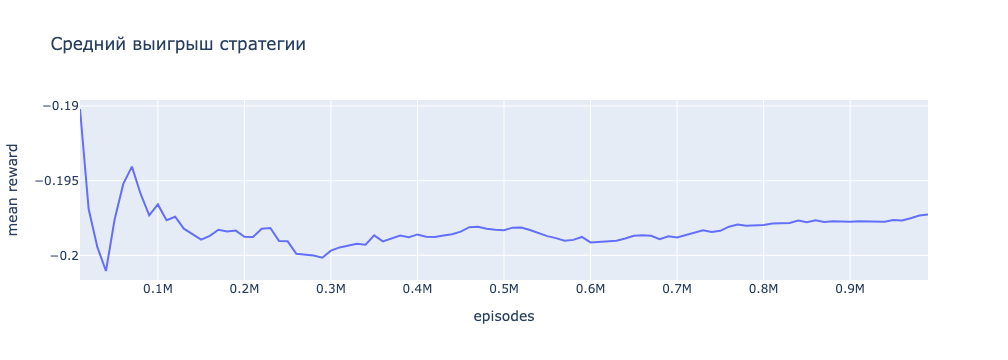

In [4]:
episodes = sorted(snapshots.keys())[1:]
y = [np.mean(rewards[:e]) for e in episodes]
px.line(x=episodes, y=y, labels={'x': 'episodes', 'y': 'mean reward'}, title='Средний выигрыш стратегии')

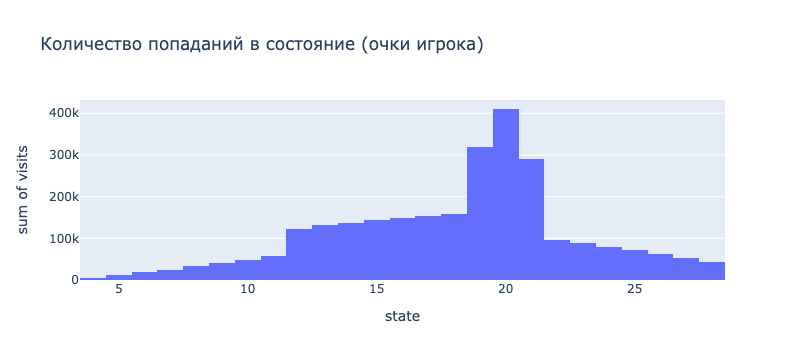

In [5]:
px.histogram(
    x=range(len(v)), y=[x[1] for x in v], nbins=len(v), 
    labels={'x': 'state', 'y': 'visits'}, 
    title='Количество попаданий в состояние (очки игрока)'
)

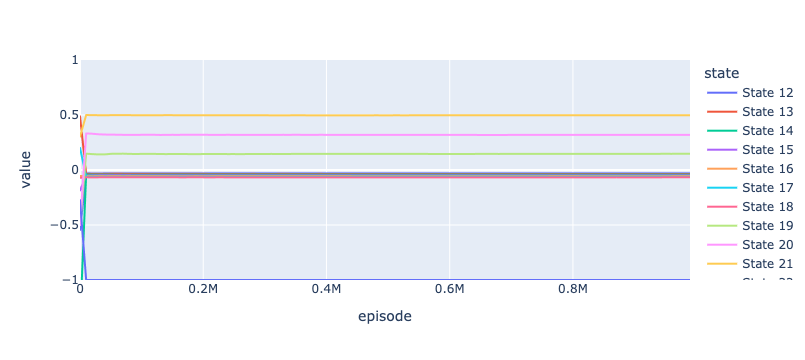

In [6]:
threshold = int(9e4)
visited_states = set(i for i in range(len(v)) if v[i][1] > threshold)
episodes = sorted(snapshots.keys())
data = []
for e in episodes:
    for state in visited_states:
        data.append({'state': f'State {state}', 'episode': e, 'value': snapshots[e][state][0]})
df = pd.DataFrame(data)
px.line(df, x='episode', y='value', color='state', range_x=[0, max(episodes)], range_y=[-1.0, 1.0])

# Часть вторая, удвоенная

Здесь нам необходимо реализовать дополнительно свою среду, которая в которой бы появилось третье действие "удвоить ставку". Для того, чтоб "помочь" игроку понять, когда нужно удваивать, добавим в состояние очки дилера и есть ли туз (usable ace).

Для обучения реализуем метод Monte-Carlo control off policy

In [7]:
def monte_carlo_control_off_policy_one_episode(env, strategy):
    states = [env.reset()]
    actions = []
    while True:
        action = strategy.next_step(states[-1])
        actions.append(action)
        s, reward, is_finished, _ = env.step(action)
        states.append(s)
        if is_finished:
            return states, actions, reward


def update_strategies(strategy_pi, strategy_b, states, actions, counts, reward, gamma):
    assert len(states) == len(actions) + 1
    gain = reward
    w = 1
    for s, a in zip(reversed(states[:-1]), reversed(actions)):
        counts[(s, a)] += w
        strategy_pi.q[(s, a)] += w / counts[(s, a)] * (gain - strategy_pi.q[(s, a)])
        if strategy_pi.q[(s, a)] > 2:
            print(f'(s, a)={(s, a)}, q={strategy_pi.q[(s, a)]}, w={w}, counts={counts[(s, a)]}, gain={gain}') 
        w *= strategy_pi.pi(s, a) / strategy_b.pi(s, a)
        gain *= gamma
        if w <= 1e-8:
            break


def init_v(observation_space):
    return [(v, 0) for v in np.random.normal(loc=0, scale=0.5, size=observation_space)]


def monte_carlo_control_off_policy(env, strategy_pi, strategy_b, episodes_number, gamma, snapshots_number, snapshot_games):
    counts = defaultdict(int)
    snapshot_each = episodes_number // snapshots_number
    rewards = {}
    snapshots = {}
    for i in trange(episodes_number):
        states, actions, reward = monte_carlo_control_off_policy_one_episode(env, strategy_b)
        update_strategies(strategy_pi, strategy_b, states, actions, counts, reward, gamma)
        if i % snapshot_each == 0:
            snapshots[i] = strategy_pi.copy()
            snapshot_rewards = []
            for _ in range(snapshot_games):
                _, _, r = monte_carlo_control_off_policy_one_episode(env, strategy_pi)
                snapshot_rewards.append(r)
            rewards[i] = np.mean(snapshot_rewards)
    return rewards, snapshots

In [8]:
importlib.reload(bj)
importlib.reload(my_strategies)
env = bj.BlackjackWithDouble()
# monte_carlo_control_off_policy_one_episode(env, my_strategies.QStrategy(0.1, actions_count=env.action_space.n))
# strategy_pi = my_strategies.QStrategy(epsilon=0.0, actions_count=env.action_space.n)
strategy_pi = my_strategies.DiscreteQStrategy(actions_count=env.action_space.n)
strategy_b = my_strategies.QStrategy(epsilon=0.1, actions_count=env.action_space.n)
snapshot_games = 100000
rewards, snapshots = monte_carlo_control_off_policy(env, strategy_pi, strategy_b, 1000000, gamma=0.1, snapshots_number=100, snapshot_games=snapshot_games)
print(f'Total states in Q: {len(strategy_pi.get_played_states())}, state * action in Q: {len(strategy_pi.q)}')

100%|████████████████████████████████████████████████████| 1000000/1000000 [15:15<00:00, 1092.06it/s]

Total states in Q: 280, state * action in Q: 840


In [9]:
def get_best_action_per_states(strategy):
    best_action = defaultdict(int)
    for state in strategy.get_played_states():
        best_action[strategy.next_step(state)] += 1
    return best_action

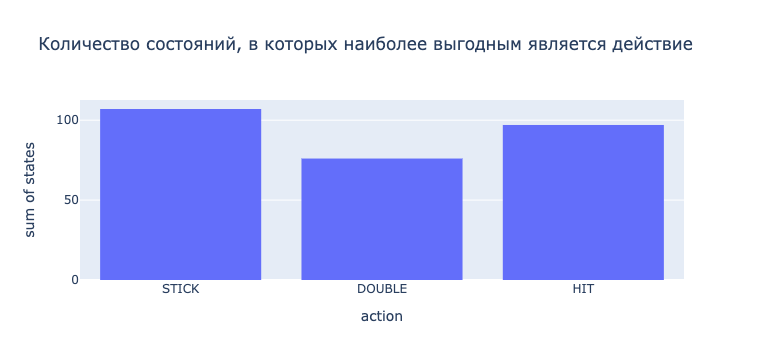

In [10]:
df = pd.DataFrame(data=[{'action': bj.Action(key).name, 'states': value} for key, value in get_best_action_per_states(strategy_pi).items()])
px.histogram(df, x='action', y='states', title="Количество состояний, в которых наиболее выгодным является действие")

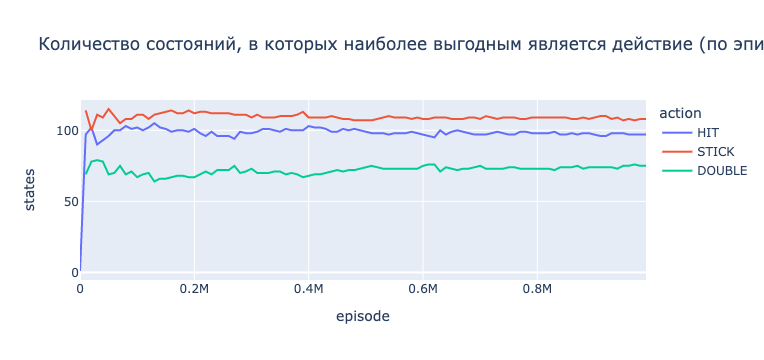

In [11]:
data = []
for episodes, strategy in snapshots.items():
    data += [{
        'action': bj.Action(key).name, 
        'states': value,
        'episode': episodes,
    } for key, value in get_best_action_per_states(strategy).items()]
px.line(pd.DataFrame(data=data), x='episode', y='states', color='action', 
        title="Количество состояний, в которых наиболее выгодным является действие (по эпизодам)")

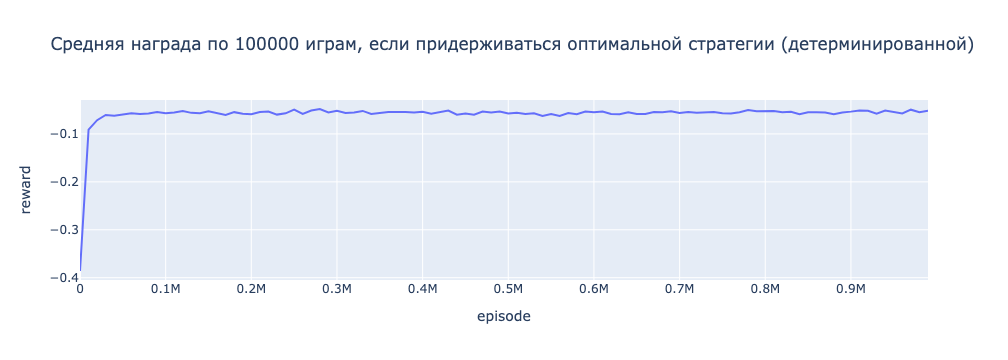

In [12]:
df = pd.DataFrame(data=[{'episode': key, 'reward': value} for key, value in rewards.items()])
px.line(df, x='episode', y='reward',
        title=f"Средняя награда по {snapshot_games} играм, если придерживаться оптимальной стратегии (детерминированной)")

#### Примеры состояний, в которых выгодны и не выгодны действия агента (разбитые по типам действий):

In [13]:
data = []
for idx, state in enumerate(list(strategy_pi.get_played_states())):
    if not state:
        print (idx, state)
        continue
    for action in strategy_pi.possible_actions():
        data.append({
            'agent_points': state[0],
            'dealer_points': state[1],
            'usable_ace': state[2],
            'action': bj.Action(action).name,
            'q_value': strategy_pi.q[(state, action)],
        })
actionsPerState = pd.DataFrame(data=data).sort_values('q_value')
actionsPerState[actionsPerState.action == 'STICK']

agent_points  dealer_points  usable_ace action   q_value
360            12              1        True  STICK -0.876923
396             5              1       False  STICK -0.835366
819             4              1       False  STICK -0.808917
345             6              1       False  STICK -0.808511
771            13              1       False  STICK -0.790192
..            ...            ...         ...    ...       ...
51             21              8       False  STICK  0.932671
159            21              9       False  STICK  0.933403
348            21              7       False  STICK  0.938348
609            21              8        True  STICK  0.939462
492            21              9        True  STICK  0.944159

[280 rows x 5 columns]

In [14]:
actionsPerState[actionsPerState.action == 'HIT']

agent_points  dealer_points  usable_ace action   q_value
688            21             10       False    HIT -1.000000
52             21              8       False    HIT -1.000000
349            21              7       False    HIT -1.000000
466            21              1       False    HIT -1.000000
34             21              4       False    HIT -1.000000
..            ...            ...         ...    ...       ...
364            20              6        True    HIT  0.030445
259            10              6       False    HIT  0.030914
343            21              6        True    HIT  0.031541
661            21              5        True    HIT  0.033930
247            11              6       False    HIT  0.039416

[280 rows x 5 columns]

In [15]:
actionsPerState[actionsPerState.action == 'DOUBLE']

agent_points  dealer_points  usable_ace  action   q_value
314            21              5       False  DOUBLE -1.000000
53             21              8       False  DOUBLE -1.000000
467            21              1       False  DOUBLE -1.000000
350            21              7       False  DOUBLE -1.000000
161            21              9       False  DOUBLE -1.000000
..            ...            ...         ...     ...       ...
260            10              6       False  DOUBLE  0.330421
248            11              6       False  DOUBLE  0.331136
662            21              5        True  DOUBLE  0.336449
38             11              4       False  DOUBLE  0.337500
344            21              6        True  DOUBLE  0.391215

[280 rows x 5 columns]

# Часть третья, в главной роли — Дастин Хоффман

Здесь нам потребуется реализовать новую среду - BlackJack с одной колодой, чтоб можно было осуществить подсчет карт. Понятно, что мы не сможем полностью подсчитывать значение каждой карты, так как это увеличило бы количество состояний на несколько порядков $counts\_of\_cards\_in\_game^{number\_of\_cards} = 5_{cards\_from\_2\_to\_9} ^ 8 * 17_{10\_queen\_king\_jack} * 5_{ace}$

Поэтому воспользуемся для подсчета количества карт системой "плюс-минус":

Карты | Очки
--- | --- 
2, 3, 4, 5, 6 | +1
7, 8, 9 | 0
10, В, Д, К, Т | -1

Эту сумму и будет генерировать среда (исходя из своего внутреннего состояния)

In [16]:
def q_learning(env, strategy, episodes_number, gamma, alpha, epsilon, snapshots_number, snapshot_games):
    snapshot_each = episodes_number // snapshots_number if snapshots_number else int(1e12)
    rewards = {}
    snapshots = {}
    counts = defaultdict(int)
    for i in trange(episodes_number):
        s = env.reset()
        while True:
            a = strategy.next_step_mild(s, epsilon)
            next_state, reward, is_finished, _ = env.step(a)
            best_next_action = strategy.next_step(next_state)
            # print(f'q={strategy.q[(s, a)]}, reward={reward}, q_next={strategy.q[(next_state, best_next_action)]}, q_updated={strategy.q[(s, a)] + alpha * (reward + gamma * strategy.q[(next_state, best_next_action)] - strategy.q[(s, a)])}')
            strategy.q[(s, a)] += alpha * (reward + gamma * strategy.q[(next_state, best_next_action)] - strategy.q[(s, a)])
            counts[(s, a)] += 1
            s = next_state
            if is_finished:
                break

        if i % snapshot_each == 0 and snapshots_number:
            snapshots[i] = strategy.copy()
            snapshot_rewards = []
            for _ in range(snapshot_games):
                s = env.reset()
                is_finished = False
                while not is_finished:
                    s, reward, is_finished, _ = env.step(strategy.next_step(s))
                snapshot_rewards.append(reward)
            rewards[i] = np.mean(snapshot_rewards)
    return rewards, snapshots, counts

100%|█████████████████████████████████████████████████| 10000000/10000000 [08:01<00:00, 20757.14it/s]


Total states in Q: 15481, state * action in Q: 46397
Shuffles count 2871695


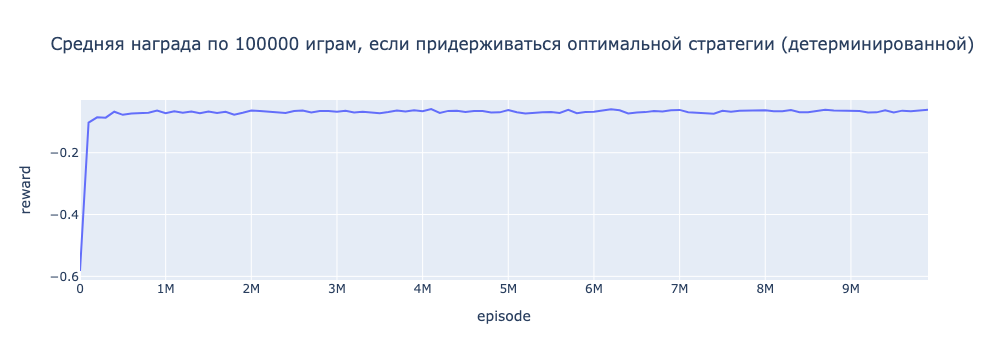

In [17]:
importlib.reload(bj)
importlib.reload(my_strategies)
# env = bj.BlackjackWithDouble()
env = bj.BlackjackOneDeck()
# monte_carlo_control_off_policy_one_episode(env, my_strategies.QStrategy(0.1, actions_count=env.action_space.n))
# strategy_pi = my_strategies.QStrategy(epsilon=0.0, actions_count=env.action_space.n)
strategy = my_strategies.DiscreteQStrategy(actions_count=env.action_space.n)
snapshot_games = 100000
rewards, snapshots, counts = q_learning(env, strategy, int(1e7), gamma=1.0, alpha=0.1, epsilon=0.1, snapshots_number=100, snapshot_games=snapshot_games)
# rewards, snapshots = q_learning(env, strategy, 10, gamma=0.1, alpha=0.8, epsilon=0.1, snapshots_number=0, snapshot_games=snapshot_games)
print(f'Total states in Q: {len(strategy.get_played_states())}, state * action in Q: {len(strategy.q)}')
print(f'Shuffles count {env.shuffle_count}')

df = pd.DataFrame(data=[{'episode': key, 'reward': value} for key, value in rewards.items()])
px.line(df, x='episode', y='reward',
        title=f"Средняя награда по {snapshot_games} играм, если придерживаться оптимальной стратегии (детерминированной)")

In [28]:
from collections import Counter
Counter(counts).most_common(10)

[(((20, 10, False, -1), 0), 57250),
 (((20, 10, False, -2), 0), 57139),
 (((14, 10, False, 0), 1), 53235),
 (((13, 10, False, 0), 1), 52368),
 (((20, 10, False, -3), 0), 51505),
 (((18, 10, False, -1), 0), 51205),
 (((12, 10, False, -1), 1), 50617),
 (((15, 10, False, -1), 1), 50466),
 (((19, 10, False, -1), 0), 49543),
 (((14, 10, False, -1), 1), 49491)]

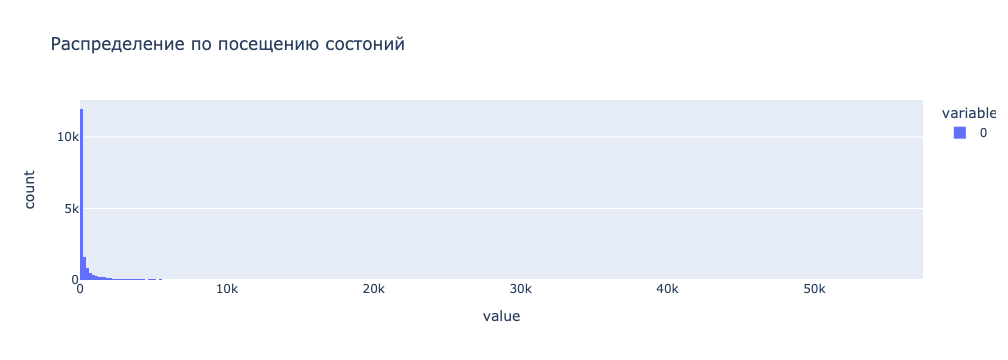

In [18]:
px.histogram(counts.values(), labels={'x': 'states'}, 
             title='Распределение по посещению состоний')

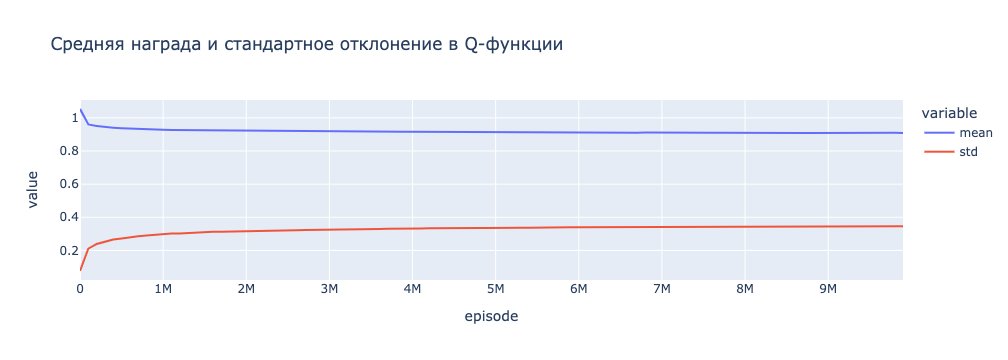

In [19]:
data = []
for episodes, strat in snapshots.items():
    data += [{
        'mean': np.mean(list(strat.q.values())), 
        'std': np.std(list(strat.q.values())),
        'episode': episodes,
    } for key, value in get_best_action_per_states(strat).items()]
px.line(pd.DataFrame(data=data), x='episode', y=['mean', 'std'], 
        title="Средняя награда и стандартное отклонение в Q-функции")

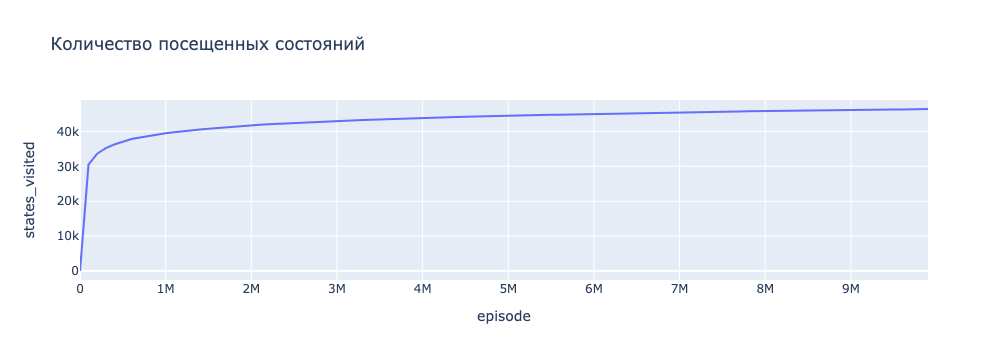

In [20]:
df = pd.DataFrame(data=[{'episode': episodes, 'states_visited': len(strat.q)} for episodes, strat in snapshots.items()])
px.line(df, x='episode', y='states_visited',
        title=f"Количество посещенных состояний")

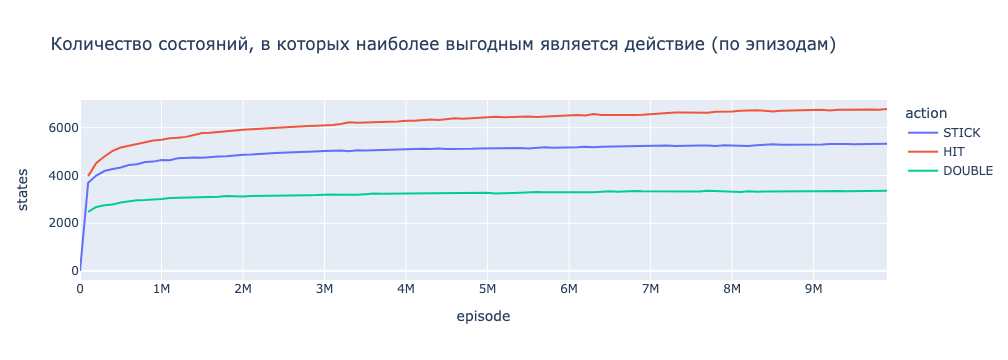

In [21]:
data = []
for episodes, strat in snapshots.items():
    data += [{
        'action': bj.Action(key).name, 
        'states': value,
        'episode': episodes,
    } for key, value in get_best_action_per_states(strat).items()]
px.line(pd.DataFrame(data=data), x='episode', y='states', color='action', 
        title="Количество состояний, в которых наиболее выгодным является действие (по эпизодам)")

#### Примеры состояний и действий (выгодных и невыгодных)

In [29]:
data = []
for state in strategy.get_played_states():
    for action in strategy.possible_actions():
        if counts.get((state, action), 0) < 100:
            continue
        data.append({
            'agent_points': state[0],
            'dealer_points': state[1],
            'usable_ace': state[2],
            'balance': state[3],
            'action': bj.Action(action).name,
            'q_value': strategy_pi.q[(state, action)],
        })
actionsPerState = pd.DataFrame(data=data).sort_values('q_value')
actionsPerState[actionsPerState.action == 'HIT']

agent_points  dealer_points  usable_ace  balance action   q_value
1054            21              3        True        2    HIT  0.645643
7699             9              6       False       -5    HIT  0.657978
2766            13              8       False        4    HIT  0.686668
7361            10              2       False        6    HIT  0.690411
808              4             10       False       -4    HIT  0.699361
...            ...            ...         ...      ...    ...       ...
4126            10              4       False       -6    HIT  1.354256
5318            17              4       False        3    HIT  1.360014
3002            13              4        True        1    HIT  1.382437
7428            15              3       False        1    HIT  1.383960
119             17              4        True       -1    HIT  1.390900

[3455 rows x 6 columns]

In [30]:
actionsPerState[actionsPerState.action == 'DOUBLE']

agent_points  dealer_points  usable_ace  balance  action   q_value
4018            21              5        True        2  DOUBLE  0.677569
613             13              5        True        0  DOUBLE  0.705162
905             20              7       False        4  DOUBLE  0.712273
3624            12              7       False       -3  DOUBLE  0.713145
6210            11              7       False        5  DOUBLE  0.716952
...            ...            ...         ...      ...     ...       ...
7767             5             10       False       -1  DOUBLE  1.296287
5605            21              8       False        2  DOUBLE  1.328997
5653            14              4       False        0  DOUBLE  1.352535
5159            13             10       False       -4  DOUBLE  1.355472
5096            14              6        True        0  DOUBLE  1.371525

[1880 rows x 6 columns]

# Поиск с известной стратегией

Для начала обучим вероятности переходов между состояниями. 

In [3]:
env = gym.make('Blackjack-v1')
env_pi = defaultdict(lambda: defaultdict(int))
episodes_number = int(1e8)
wins_count, sum_reward = 0, 0.0
snapshots_count = 100
snapshots_each = episodes_number // snapshots_count if snapshots_count else int(1e9)
snapshots = {}
for i in trange(int(episodes_number)):
    s = env.reset()
    is_finished = False
    while not is_finished:
        a = env.action_space.sample()
        next_s, reward, is_finished, _ = env.step(a)
        env_pi[(s, a)][(next_s, reward)] += 1
        s = next_s
    wins_count += reward > 0
    sum_reward += reward
    if i % snapshots_each == 0 and snapshots_count > 0:
        snapshots[i] = env_pi.copy()
print(f'Wins ratio: {wins_count/episodes_number}, average reward: {sum_reward/episodes_number}')

100%|█████████████████████████████████████████████| 100000000/100000000 [1:40:23<00:00, 16601.68it/s]

Wins ratio: 0.28238201, average reward: -0.39406437


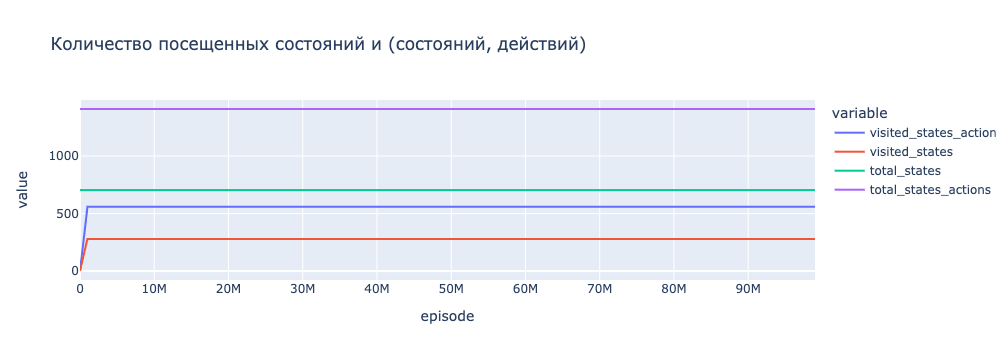

In [4]:
data = []
for episodes, pi in snapshots.items():
    data += [{
        'total_states': np.prod([x.n for x in env.observation_space]),
        'total_states_actions': np.prod([x.n for x in env.observation_space] + [env.action_space.n]),
        'visited_states_actions': len(pi), 
        'visited_states': len(set(x[0] for x in pi)),
        'episode': episodes,
    }]
px.line(pd.DataFrame(data=data), x='episode', 
        y=['visited_states_actions', 'visited_states', 'total_states', 'total_states_actions'], 
        title="Количество посещенных состояний и (состояний, действий)")

Будем решать уравнение Беллмана для $Q(s, a)$. Из обученной ранее модели среды у нас есть вероятности переходов:
$$p(s, a, s', r)$$

Далее нам предстоит решить систему линейных уравнений:
$$Q(s, a) = \mathbb{E_{\pi}} [G_t | S_t = s, A_t = a] = \sum_{s', r} p(s, a, s', r) (r + \gamma Q^*(s', a'))$$

Воспользуемся итеративным процессом поиска решения до сходимости (будем итеративно обновлять $Q(s, a)$ до тех пор, пока изменения будут больше $\epsilon$)

In [41]:
import pickle

with open('env_pi.dmp', 'wb') as fo:
    pickle.dump(dict(env_pi), fo)

  0%|                                                        | 16/1000000 [00:00<1:50:18, 151.08it/s]


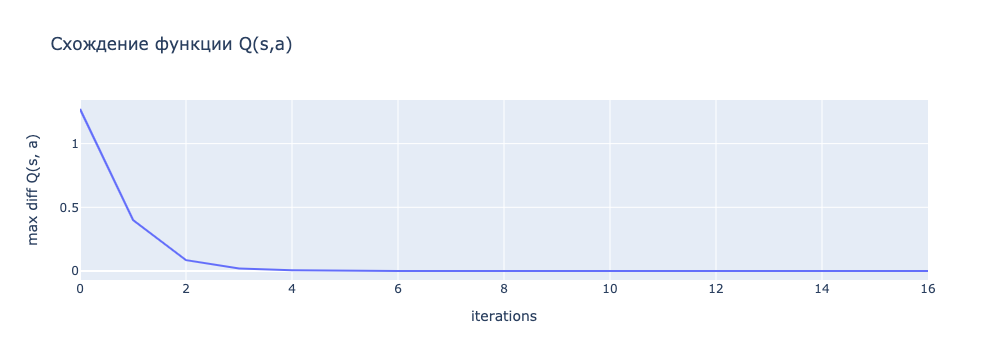

In [48]:
def get_best_q(Q, state):
    q = -1e9
    best_a = None
    for a in range(env.action_space.n):
        if Q[(state, a)] > q:
            q = Q[(state, a)]
            best_a = a
    return q, best_a


Q = defaultdict(lambda: np.random.normal(loc=0.0, scale=0.2))
gamma = 0.9
epsilon = 1e-8
diffs = []

MAX_ITERATIONS = int(1e6)
for i in trange(MAX_ITERATIONS):
    max_diff = 0.0
    for (s, a), outs in env_pi.items():
        total_outs = sum(outs.values())
        new_q = 0.0
        for (next_s, reward), count in outs.items():
            p = count / total_outs
            best_next_q, _ = get_best_q(Q, next_s)
            if abs(reward) > 1e-9:
                best_next_q = 0.0  # we know that it's terminal state
            new_q += p * (reward + gamma * best_next_q)
        if new_q > 1.0:
            print(Q[(s, a)], new_q)
            for (next_s, reward), count in outs.items():
                p = count / total_outs
                best_next_q, _ = get_best_q(Q, next_s)
                print(f'\tp={p}, reward={reward}, best_next_q={best_next_q}, -> {p * (reward + gamma * best_next_q)}')
        max_diff = max(max_diff, abs(new_q - Q[(s, a)]))
        Q[(s, a)] = new_q
    diffs.append(max_diff)
    if max_diff < epsilon:
        print
        break
px.line(
    x=list(range(len(diffs))), y=diffs, 
    labels={'x': 'iterations', 'y': 'max diff Q(s, a)'},
    title="Схождение функции Q(s,a)"
)

#### Обученная функция $Q(s, a)$

In [49]:
data = [{
    'user_points': user_points,
    'dealer_points': dealer_points,
    'usable_ace': usable_ace,
    'action': bj.Action(a).name,
    'value': value,
} for ((user_points, dealer_points, usable_ace), a), value in Q.items()]
pd.DataFrame(data=data).sort_values('value')

user_points  dealer_points  usable_ace action     value
500           21              6       False    HIT -1.000000
330           21              7       False    HIT -1.000000
47            21             10       False    HIT -1.000000
51            21              2       False    HIT -1.000000
181           21              5       False    HIT -1.000000
..           ...            ...         ...    ...       ...
209           21              5        True  STICK  0.998716
153           21              6        True  STICK  0.998848
440           21              7        True  STICK  0.999069
584           21              8        True  STICK  0.999153
414           21              9        True  STICK  0.999262

[760 rows x 5 columns]

In [50]:
episodes_number = int(1e6)
wins_count, sum_reward = 0, 0.0

for i in trange(int(episodes_number)):
    s = env.reset()
    is_finished = False
    while not is_finished:
        q, a = get_best_q(Q, s)
        s, reward, is_finished, _ = env.step(a)        
    wins_count += reward > 1e-8
    sum_reward += reward
print(f'Wins ratio: {wins_count/episodes_number}, average reward: {sum_reward/episodes_number}, episodes played: {episodes_number}')


100%|███████████████████████████████████████████████████| 1000000/1000000 [01:00<00:00, 16439.09it/s]

Wins ratio: 0.432827, average reward: -0.043662, episodes played: 1000000
